# Complete Meta-Learning Distribution

This notebook generates the complete meta-learning distribution for MetaChest.

In [1]:
from os import makedirs
from os.path import join

import pandas as pd

from common import MCLASSES, filter_msets, read_toml, save_toml

## Generate

In [2]:
name = 'complete'
mclasses = MCLASSES
metachest_dir = read_toml('config.toml')['metachest_dir']
df = pd.read_csv(join(metachest_dir, 'metachest.csv'))

filter_df = pd.DataFrame(
    [[1, 1, 1]] * df.shape[0],
    columns=mclasses.keys()
)
filter_msets(df, filter_df, mclasses)

mtl_dir = join(metachest_dir, 'mtl')
makedirs(join(mtl_dir))
save_toml(join(mtl_dir, f'{name}.toml'), mclasses)
filter_df.to_csv(join(mtl_dir, f'{name}.csv'), index=False)

## Explore

In [3]:
print(f'Total {df.shape[0]}')
print(df['dataset'].value_counts())

Total 322475
dataset
chexpert       130930
mimic          111869
chestxray14     50651
padchest        29025
Name: count, dtype: int64


Compute total dataframe:

In [4]:
# group by dataset
paths = list(df.columns[5:])
ds_sum_df = df[['dataset'] + paths].groupby('dataset').sum().astype(int)
# sorted pathologies and datasets sseries
ds_sum_sr = ds_sum_df.sum(axis=1).sort_values(ascending=False)
pt_sum_sr = ds_sum_df.sum(axis=0).sort_values(ascending=False)
# sort grouped df
ds_sum_df = ds_sum_df.reindex(list(ds_sum_sr.index))
ds_sum_df = ds_sum_df[list(pt_sum_sr.index)]

# total df
total_df = ds_sum_df.copy()
total_df.loc[:, 'total'] = total_df.sum(axis=1)
total_df.loc['total', :] = total_df.sum(axis=0)
total_df = total_df.astype(int)

<Axes: >

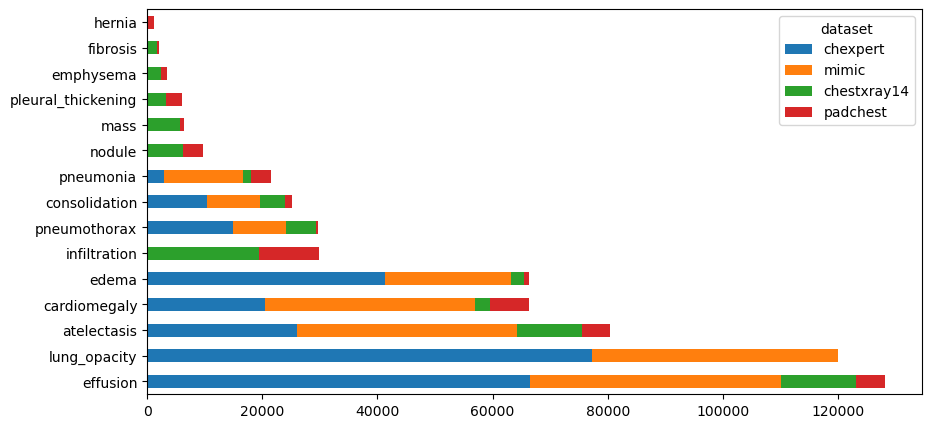

In [5]:
ds_sum_df.T.plot.barh(stacked=True, figsize=(10, 5))

In [6]:
total_df.T.iloc[::-1]

dataset,chexpert,mimic,chestxray14,padchest,total
total,259599,215103,79436,42356,596494
hernia,0,0,197,1034,1231
fibrosis,0,0,1650,489,2139
emphysema,0,0,2484,939,3423
pleural_thickening,0,0,3326,2691,6017
mass,0,0,5682,738,6420
nodule,0,0,6238,3429,9667
pneumonia,2986,13679,1381,3548,21594
consolidation,10340,9183,4505,1197,25225
pneumothorax,14977,9215,5220,306,29718


### Partition

In [7]:
mtrn, mval, mtst = MCLASSES.values()
mset = total_df[mtrn + mval + mtst].T
mset_vals = ['mtrn'] * len(mtrn) + ['mval'] * len(mval) + ['mtst'] * len(mtst)
mset.insert(0, 'mset', mset_vals)
mset

dataset,mset,chexpert,mimic,chestxray14,padchest,total
effusion,mtrn,66484,43544,13086,5075,128189
lung_opacity,mtrn,77194,42779,0,0,119973
atelectasis,mtrn,25980,38297,11335,4808,80420
infiltration,mtrn,0,0,19362,10455,29817
nodule,mtrn,0,0,6238,3429,9667
mass,mtrn,0,0,5682,738,6420
pleural_thickening,mtrn,0,0,3326,2691,6017
emphysema,mval,0,0,2484,939,3423
fibrosis,mval,0,0,1650,489,2139
hernia,mval,0,0,197,1034,1231


In [8]:
mset.groupby('mset', sort=False).sum()

dataset,chexpert,mimic,chestxray14,padchest,total
mset,,,,,
mtrn,169658,124620,59029,27196,380503
mval,0,0,4331,2462,6793
mtst,89941,90483,16076,12698,209198


In [9]:
ds_sum_df

,effusion,lung_opacity,atelectasis,cardiomegaly,edema,infiltration,pneumothorax,consolidation,pneumonia,nodule,mass,pleural_thickening,emphysema,fibrosis,hernia
dataset,,,,,,,,,,,,,,,
chexpert,66484,77194,25980,20391,41247,0,14977,10340,2986,0,0,0,0,0,0
mimic,43544,42779,38297,36512,21894,0,9215,9183,13679,0,0,0,0,0,0
chestxray14,13086,0,11335,2701,2269,19362,5220,4505,1381,6238,5682,3326,2484,1650,197
padchest,5075,0,4808,6782,865,10455,306,1197,3548,3429,738,2691,939,489,1034


<Axes: >

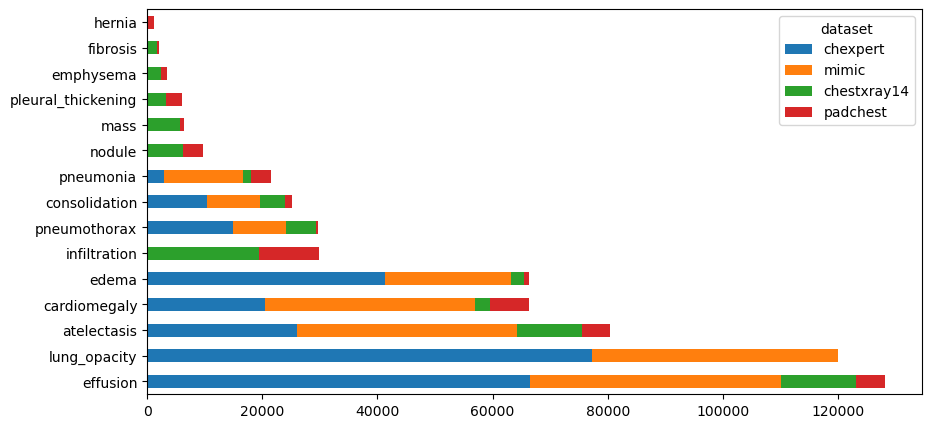

In [10]:
ds_sum_df.T.plot.barh(stacked=True, figsize=(10, 5))

In [11]:
ds_sum_df.sum(axis=0)

effusion              128189
lung_opacity          119973
atelectasis            80420
cardiomegaly           66386
edema                  66275
infiltration           29817
pneumothorax           29718
consolidation          25225
pneumonia              21594
nodule                  9667
mass                    6420
pleural_thickening      6017
emphysema               3423
fibrosis                2139
hernia                  1231
dtype: int64

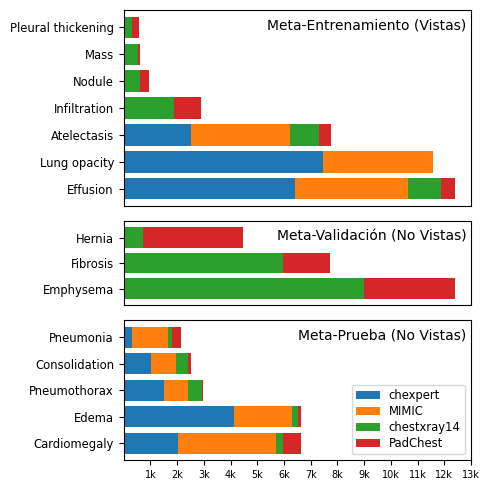

In [12]:
import matplotlib.pyplot as plt

def plot_metasets(ds, mclasses, figsize=(5,5)):
    titles = ['Meta-Entrenamiento (Vistas) ', 'Meta-Validación (No Vistas) ', 'Meta-Prueba (No Vistas) ']
    fig, axs = plt.subplots(
        nrows=len(mclasses), ncols=1, tight_layout=True,
        gridspec_kw={'height_ratios': [len(mset) for mset in mclasses]},
        figsize=figsize,
    )
    for mset, title, ax in zip(mclasses, titles, axs):
        ds_mset = ds[mset]
        cols = {col: col.replace('_', ' ').capitalize() for col in ds_mset.columns}
        idxs = {'chex': 'CheX', 'mimic': 'MIMIC', 'nih': 'NIH', 'padchest': 'PadChest'}
        ds_mset = ds_mset.rename(columns=cols, index=idxs)
        ax = ds_mset.T.plot.barh(stacked=True, width=0.8, ax=ax)
        ax.set_xticks([],[])
        ax.set_title(title, fontsize=10, loc='right', y=1.0, pad=-14)
        if 'Pru' in title:
            ax.legend(loc='lower right', fontsize='small', labelspacing=0.25)
        else:
            ax.get_legend().remove()
        ax.tick_params(axis='y', which='major', labelsize='small')
    xticks = [x for x in range(10000, 130001, 10000)]
    ax.set_xticks(xticks, [f'{x//10000}k' for x in xticks], fontsize=7)

plot_metasets(ds_sum_df, MCLASSES.values())